In [2]:
from utils import *
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import warnings
from scipy.stats import pearsonr 
from src.files.kofamscan import KofamscanFile

%load_ext autoreload 
%autoreload 2

# NOTE: The n_bottom_2024 transcriptome library is a bit on the small size. 

In [3]:
mp_genome_ids = ['mp_15', 'mp_1', 'mp_5', 'mp_12', 'mp_7', 'mp_4', 'mp_18', 'mp_16', 'mp_20'] # From sandbox-1.ipynb
mp_genome_ids = ['mp_7', 'mp_4', 'mp_18', 'mp_16', 'mp_20']
# ref_gene_ids = {genome_id:df.gene_id.unique() for genome_id, df in pd.read_csv('ref_genes.csv', comment='#').groupby('genome_id')}

In [4]:
coverm_df = coverm_load('../data/coverm/all.tsv', contig_sizes=contig_sizes)
coverm_df = coverm_df[coverm_df.reactor == 'n'].copy()
coverm_df['sample_id'] = coverm_df.sample_id.str.replace('n_', '')

metat_df = metat_load(data_dir='../data/metat/', group_genomes=False)
metat_df = metat_df[metat_df.reactor == 'n'].copy()
metat_df['sample_id'] = metat_df.sample_id.str.replace('n_', '')
metat_df['genome_size'] = metat_df.length
metat_df = metat_df[~metat_df.gene_id.isin(['mp_18.1_2492', 'mp_18.1_2493'])].copy()

interproscan_df = load_interproscan()
interproscan_df = interproscan_df[interproscan_df.e_value < 1e-5].copy()
interproscan_df['gene_id'] = interproscan_df['id']

kofamscan_df = load_kofamscan()

In [5]:
# mp_15 is SR-VP_9_9_2021_34_2B_1_4m_PACBIO-HIFI_HIFIASM-META_Methanoperedens_41_19_curated_41_3

In [6]:

# Supplementing the Kofamscan results. 
annotations = dict()
annotations['mp_16.1_538'] = 'hypothetical protein'
annotations['mp_16.1_2619'] = 'multiheme cytochrome'
annotations['mp_16.1_2527'] = 'hypothetical protein'
annotations['mp_16.1_106'] = 'S-layer related duplication domain protein'
annotations['mp_16.1_2530'] = 'post-COAP-1 domain-containing protein' #  Found in a subset of proteins with the choice-of-anchor P (COAP) domain (see NF040603). 
annotations['mp_16.1_2528'] = 'hypothetical protein'
annotations['mp_16.1_162'] = 'S-layer related duplication domain protein'

annotations['mp_18.1_2548'] = 'S-layer related duplication domain protein'
annotations['mp_18.1_828'] = 'carboxypeptidase-like regulatory domain, immunoglobulin-like fold'
annotations['mp_18.1_2365'] = 'multiheme cytochrome, immunoglobulin-like fold'
annotations['mp_18.1_2218'] = 'YVTN beta-propeller repeat domain-containing protein'
annotations['mp_18.1_2776'] = 'multiheme cytochrome'
annotations['mp_18.1_2217'] = 'YVTN beta-propeller repeat domain-containing protein'
annotations['mp_18.1_2006'] = 'multiheme cytochrome, immunoglobulin-like fold'
annotations['mp_18.1_1276'] = 'immunoglobulin-like fold, type VI secretion system VgrG/RHS' # Secretion system annotation from InterProScan.
annotations['mp_18.1_2366'] = 'multiheme cytochroms, immunoglobulin-like fold' # Secretion system annotation from InterProScan

annotations['mp_4.1_1795'] = 'hypothetical protein' 
annotations['mp_4.1_2543'] = 'S-layer related duplication domain protein'
annotations['mp_4.1_1780'] = 'S-layer-related duplication domain protein' # From ggKbase Genbank file. 
annotations['mp_4.1_1854'] = 'eCIS core domain' # phosphoribosylaminoimidazole-succinocarboxamide synthase from ggKbase.
annotations['mp_4.1_1307'] = 'immunoglobulin-like fold'
annotations['mp_4.1_1297'] = 'APHP domain-containing protein' # PGF-pre-PGF domain from InterProScan.
annotations['mp_4.1_741'] = 'dystroglycan-type cadherin-like protein'
annotations['mp_4.1_2655'] = 'hypothetical protein'
annotations['mp_4.1_2905'] = 'multi-sensor hybrid histidine kinase'
annotations['mp_4.1_574'] = 'EmrB/QacA subfamily drug resistance transporter'

In [7]:
interproscan_df[interproscan_df.gene_id == 'mp_18.1_2366'].drop_duplicates('interpro_accession')

,id,md5,length,signature_analysis,signature_accession,signature_description,start,stop,e_value,status,date,interpro_accession,interpro_description,genome_id,gene_id
12704,mp_18.1_2366,f946812fc1a3de8efec313e212549374,1674,Gene3D,G3DSA:2.60.40.10,Immunoglobulin-like fold,1500,1581,9.100000e-11,T,02-01-2026,IPR013783,Immunoglobulin-like fold,mp_18,mp_18.1_2366
12703,mp_18.1_2366,f946812fc1a3de8efec313e212549374,1674,Pfam,PF01833,IPT domain,1501,1581,1.800000e-07,T,02-01-2026,IPR002909,IPT domain,mp_18,mp_18.1_2366
12706,mp_18.1_2366,f946812fc1a3de8efec313e212549374,1674,SUPERFAMILY,SSF48695,Multiheme cytochrome superfamily,1168,1484,3.070000e-12,T,02-01-2026,IPR036280,Multiheme cytochrome superfamily,mp_18,mp_18.1_2366
12707,mp_18.1_2366,f946812fc1a3de8efec313e212549374,1674,SUPERFAMILY,SSF81296,Immunoglobulin E-set,1500,1583,2.800000e-10,T,02-01-2026,IPR014756,Immunoglobulin E-set,mp_18,mp_18.1_2366


In [8]:
def print_top_n_genes(genome_id:str, location:str='top', year:str='2025', n:int=10, annotations=annotations):
    df = metat_df.sort_values('read_count', ascending=False)

    kofamscan_df = KofamscanFile.from_file(f'../data/kofamscan/{genome_id}.txt').to_df()
    df = df[(df.year == year) & (df.genome_id == genome_id) & (df.location == location)].copy()
    total = df.read_count.sum()
    df = df.iloc[:n].copy()
    
    df = df.merge(kofamscan_df, on='gene_id', how='left')
    df = df.drop_duplicates(['gene_id', 'definition'])
    # df['definition'] = df.definition.fillna('')
    df['definition'] = np.where(df.definition.isnull(), df.gene_id.map(annotations), df.definition)

    print(genome_id, end='\n\n')
    for i, row in enumerate(df.itertuples()):
        print(f'{i + 1}. {row.gene_id} {row.definition} {100 * row.read_count / total:.2f}%')
    print(f'\nTotal explained: {100 * df.read_count.sum() / total:.2f}%')

# print_top_n_genes('mp_4', location='middle', year='2025')
print_top_n_genes('mp_18', location='middle', year='2025')

# Adjacent to lots of tRNA genes. 
# mp_18.1_2493 FINAL_2-50MB_Methanoperedens_SR-VP_07_25_2022_A1_90cm_PACBIO-HIFI_44_8_complete_2493
# MNPGPTGCSRRENFTLLEIAIRGPRVPVPSTGCPAVQTTVVSKGRARPVPAAAVTPAARVVAVIIGFKGSVAGLLSLLGNLAA
# Completely overlaps 16S rRNA FINAL_2-50MB_Methanoperedens_SR-VP_07_25_2022_A1_90cm_PACBIO-HIFI_44_8_complete_16S_1
# https://pmc.ncbi.nlm.nih.gov/articles/PMC212001/
# https://pmc.ncbi.nlm.nih.gov/articles/PMC2859892/

# Immediately upstream of the rRNA on the complementary strand (same strand as mp_18.1_2493)
# tRNA also seems to overlap the rRNA, possibly encoded within the same operon. 
# mp_18.1_2492 FINAL_2-50MB_Methanoperedens_SR-VP_07_25_2022_A1_90cm_PACBIO-HIFI_44_8_complete_2492
# MVRSRRMRDGESRLIPGDREKGTECPYQEPTLVPLVEKTKACRHKLAKGIRQISSVTSGEGVPALKKAGRRDQGALTV
# mp_18.1_2548 is an S-layer protein

# mp_18.1_2492 complement(2235835..2236071)
# tRNA 2237851..2237923
# 16S rRNA 2238020..2239487
# mp_18.1_2493 complement(2238931..2239182)

mp_18

1. mp_18.1_2147 methyl-coenzyme M reductase alpha subunit  19.97%
2. mp_18.1_2150 methyl-coenzyme M reductase beta subunit  14.54%
3. mp_18.1_2548 S-layer related duplication domain protein 11.59%
4. mp_18.1_828 carboxypeptidase-like regulatory domain, immunoglobulin-like fold 7.20%
5. mp_18.1_2365 multiheme cytochrome, immunoglobulin-like fold 3.85%
6. mp_18.1_2149 methyl-coenzyme M reductase subunit D 2.65%
7. mp_18.1_2218 YVTN beta-propeller repeat domain-containing protein 2.54%
8. mp_18.1_2776 multiheme cytochrome 2.46%
9. mp_18.1_2148 methyl-coenzyme M reductase gamma subunit  2.41%
10. mp_18.1_2217 YVTN beta-propeller repeat domain-containing protein 1.72%

Total explained: 68.95%


NameError: name 'vlr_diff_df' is not defined

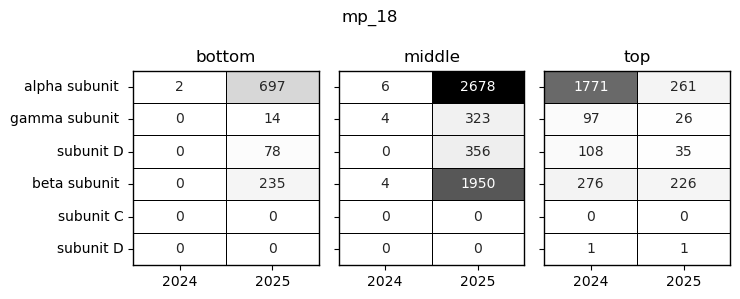

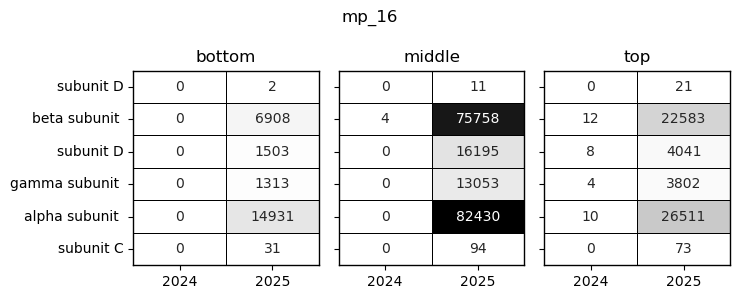

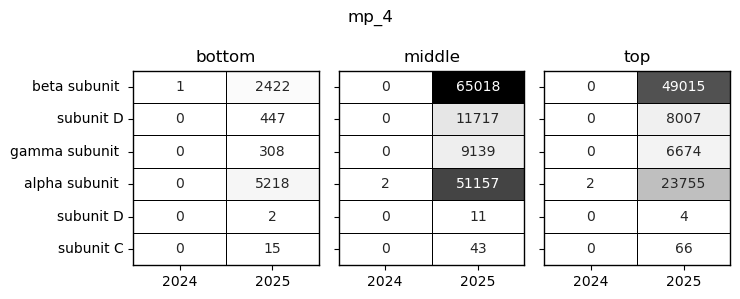

In [9]:
mcr_gene_ids = kofamscan_df[kofamscan_df.definition.str.contains('methyl-coenzyme M reductase')].gene_id.unique()

def plot_mcr_read_counts(genome_id:str, gene_ids=mcr_gene_ids, metat_df:pd.DataFrame=metat_df, kofamscan_df:pd.DataFrame=kofamscan_df):
    figure_df = metat_df[(metat_df.genome_id == genome_id) & (metat_df.gene_id.isin(gene_ids))].copy()

    annotation_df = kofamscan_df[kofamscan_df.gene_id.isin(gene_ids)].copy()
    annotation_df = annotation_df[['gene_id', 'definition']].rename(columns={'definition':'annotation'})
    annotation_df['annotation'] = annotation_df.annotation.str.replace('methyl-coenzyme M reductase ', '')
    figure_df = figure_df.merge(annotation_df, on='gene_id', how='left')
    figure_df = figure_df.drop_duplicates(['gene_id', 'sample_id'])
    figure_df = figure_df[~figure_df.annotation.isnull()]
    figure_df = figure_df.sort_values('annotation')

    fig, axes = plt.subplots(figsize=(2.5 * 3, 3), ncols=3, sharey=True)
    v_min, v_max = figure_df.read_count.min(), figure_df.read_count.max()

    for ax, (location, df) in zip(axes, figure_df.groupby('location')):
        df = df.pivot(columns='year', index='gene_id', values='read_count')
        plot_read_counts(df, v_min=v_min, v_max=v_max, ax=ax, title=location)
        # df = df[(df['2024'] > 0) | (df['2025'] > 0)].copy()
    axes[0].set_yticks(axes[0].get_yticks(), [figure_df[figure_df.gene_id == label.get_text()].annotation.iloc[0] for label in axes[0].get_yticklabels()])

    fig.suptitle(genome_id)
    fig.tight_layout()
    plt.show()

plot_mcr_read_counts('mp_18')
plot_mcr_read_counts('mp_16')
plot_mcr_read_counts('mp_4')

In [10]:


# def plot_rpkm_correlation(metat_df, gene_ids:list=None, ax=None, title:str='', log_scale:bool=False, genome_id='mp_18', threshold=10, min_samples=3, metric='geometric_mean'):
#     # Make sure to filter genome IDs before mzr. 
#     metat_df = metat_df[metat_df.genome_id == genome_id].copy()
#     metat_df = metat_filter(metat_df, threshold=threshold, min_samples=min_samples, field='read_count')
#     print('plot_rpkm_correlation: Num. genes passing the filter:', metat_df.gene_id.nunique())
#     metat_df = metat_add_pseudocounts(metat_df, method='mzr')

#     figure_df = metat_df[metat_df.gene_id.isin(gene_ids)].copy() if gene_ids is not None else metat_df.copy()

#     if metric == 'geometric_mean':
#         figure_df = figure_df.groupby(['sample_id', 'genome_id']).apply(lambda df : gmean(df.read_count.values), include_groups=False).reset_index(name='geometric_mean')
#     elif metric == 'median':
#         figure_df = figure_df.groupby(['sample_id', 'genome_id']).apply(lambda df : df.read_count.median(), include_groups=False).reset_index(name='median')

#     figure_df = figure_df.set_index(['sample_id', 'genome_id'])
#     figure_df['rpkm'] = metat_df.groupby(['sample_id', 'genome_id']).apply(lambda df : (df.read_count.sum() / (df.genome_size.sum() / 1e3) / (df.library_size.iloc[0] / 1e6)), include_groups=False)
#     figure_df = figure_df.reset_index(drop=False)
#     # print(f'plot_rpkm_correlation: Num instances with the mean rounding to zero for plot {title}: {(figure_df.geometric_mean == 0).sum()}')
#     if log_scale:
#         figure_df['rpkm'] = np.log10(figure_df.rpkm)
#         # figure_df['geometric_mean'] = np.log10(figure_df.geometric_mean)
#         figure_df[metric] = np.log10(figure_df[metric].values)

#     sns.scatterplot(figure_df, x='rpkm', y=metric, ax=ax, color='gray')


#     # result = pearsonr(figure_df.rpkm, figure_df.geometric_mean)
#     # m, b = np.polyfit(figure_df.rpkm, figure_df.geometric_mean, deg=1)

#     result = pearsonr(figure_df.rpkm, figure_df[metric])
#     m, b = np.polyfit(figure_df.rpkm, figure_df[metric], deg=1)
#     text = f'$R=${result.statistic:.2f}\n'
#     text += f'$p=${result.pvalue:.2f}\n'
#     text += fr'$\alpha=${m:.2f}' + '\n'
#     text += fr'$\beta=${b:.2f}'
#     ax.text(0.65, 0.25, text, transform=ax.transAxes)

#     ax.set_xlabel('activity'  if not log_scale else 'log$_{10}$(activity)')
#     metric = metric.replace('_', ' ')
#     ax.set_ylabel(metric if not log_scale else 'log$_{10}$' + f'({metric})')
#     ax.set_title(title)

#     return figure_df


# fig, axes = plt.subplots(figsize=(3 * 4, 3), ncols=4)

# metric = 'median'
# location = 'top'

# figure_df = metat_df[metat_df.location.isin(['middle', 'bottom', 'top'])].copy()
# plot_rpkm_correlation(figure_df, ax=axes[0], title='mp_18', log_scale=True, genome_id='mp_18', threshold=5, min_samples=2, metric=metric)
# plot_rpkm_correlation(figure_df, ax=axes[1], title='mp_16', log_scale=True, genome_id='mp_16', threshold=10, min_samples=3, metric=metric)
# plot_rpkm_correlation(figure_df, ax=axes[2], title='mp_4', log_scale=True, genome_id='mp_4', threshold=10, min_samples=3, metric=metric)
# plot_rpkm_correlation(figure_df, ax=axes[3], title='mp_20', log_scale=True, genome_id='mp_20', threshold=10, min_samples=3, metric=metric)


# fig.tight_layout()
# fig.suptitle(location)
# plt.show()
 

In [11]:
# thresholds = {'mp_18':5, 'mp_16':10, 'mp_4':10, 'mp_20':10}
# min_samples = {'mp_18':2, 'mp_16':3, 'mp_4':3, 'mp_20':3}
# metat_df = pd.concat([metat_filter(df, threshold=thresholds[genome_id], min_samples=min_samples[genome_id]) for genome_id, df in metat_df.groupby('genome_id') if (genome_id in thresholds)])


In [12]:

def plot_diff_distribution(metat_df, location='', quantile=None, genome_id='mp_18', ax=None, color='lightgray'):
    figure_df = metat_get_diff(metat_df, genome_id=genome_id, normalization='clr')
    sns.kdeplot(figure_df, x='diff', common_norm=False, color=color, ax=ax, label=location)

    if quantile is not None:
        up_threshold = np.quantile(figure_df['diff'].values, 1 - quantile).item()
        down_threshold = np.quantile(figure_df['diff'].values, quantile).item()
        ax.axvline(up_threshold, ls='--', color='black', lw=0.7)
        ax.axvline(down_threshold, ls='--', color='black', lw=0.7)    
    ax.set_ylabel('density')

        

In [13]:

# genome_id = 'mp_18'
# fig, ax = plt.subplots(figsize=(3, 3))

# palette = {'top':'lightblue', 'middle':'steelblue', 'bottom':'gray'}
# for (location, df) in metat_df.groupby('location'):
#     plot_diff_distribution(df, ax=ax, color=palette[location], location=location, genome_id=genome_id)

# ax.axvline(2.5, ls='--', color='black', lw=0.7)
# ax.axvline(-2.5, ls='--', color='black', lw=0.7)
# ax.legend()
    
# ax.set_title(genome_id)
# plt.show()

In [14]:
diff_df = metat_get_diff(metat_df[metat_df.location == 'top'], genome_id='mp_18', normalization='clr')
diff_df = diff_df[diff_df['diff'] > 2.5].copy()

kofamscan_df = KofamscanFile.from_file('../data/kofamscan/mp_18.txt').to_df(parse_ecs=True)
diff_df = diff_df.merge(kofamscan_df, on='gene_id', how='left')
# diff_df = diff_df.merge(interproscan_df.drop(columns=['genome_id']), on='gene_id', how='left')
print('Num. genes up-regulated:', diff_df.gene_id.nunique())
print('Num. with no annotation:', diff_df[diff_df.definition.isnull()].gene_id.nunique())

# for hmm, df in diff_df.groupby('signature_analysis', observed=True):
#     print(f'Num. with a {hmm} annotation:', df.gene_id.nunique())

diff_df

metat_get_diff: Removed 1250 genes with zero expression in both samples.
Num. genes up-regulated: 321
Num. with no annotation: 182


,gene_id,diff,genome_id,ko,threshold,score,e_value,definition,ec_1,ec_2,ec_3,ec_4
0,mp_18.1_1010,4.988335,mp_18,K03809,60.50,66.3,4.100000e-19,NAD(P)H dehydrogenase (quinone),1,6,5,2
1,mp_18.1_1011,4.295188,mp_18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,mp_18.1_1012,5.393800,mp_18,K18779,255.50,661.9,9.100000e-200,7-cyano-7-deazaguanine tRNA-ribosyltransferase,2,4,2,48
3,mp_18.1_1032,4.988335,mp_18,K08264,308.37,463.1,1.100000e-139,heterodisulfide reductase subunit D,1,8,98,1
4,mp_18.1_1042,4.295188,mp_18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
336,mp_18.1_961,5.393800,mp_18,K11784,444.47,519.9,1.700000e-156,cyclic dehypoxanthinyl futalosine synthase,1,21,98,1
337,mp_18.1_982,3.889723,mp_18,K03657,366.50,474.0,2.000000e-142,ATP-dependent DNA helicase UvrD/PcrA,5,6,2,4
338,mp_18.1_983,12.559467,mp_18,K06218,47.63,68.5,1.400000e-19,mRNA interferase RelE/StbE,-,-,-,-
339,mp_18.1_987,5.045494,mp_18,K02004,52.83,103.4,1.700000e-30,putative ABC transport system permease protein,-,-,-,-


In [15]:
diff_df = metat_get_diff(metat_df[metat_df.location == 'bottom'], genome_id='mp_18', normalization='clr')
diff_df = diff_df[diff_df['diff'] < -2.5].copy()
diff_df = diff_df.merge(interproscan_df.drop(columns=['genome_id']), on='gene_id', how='left')
print('Num. genes down-regulated:', diff_df.gene_id.nunique())
print('Num. with no annotation:', diff_df[diff_df.signature_accession.isnull()].gene_id.nunique())
print('Num. with an InterPro description:', diff_df[(diff_df.interpro_description != '-') & (~diff_df.interpro_accession.isnull())].gene_id.nunique(), end='\n\n')

# for hmm, df in diff_df.groupby('signature_analysis', observed=True):
#     print(f'Num. with a {hmm} annotation:', df.gene_id.nunique())

diff_df = diff_df[['gene_id', 'diff', 'interpro_accession', 'interpro_description']].copy()
diff_df = diff_df.rename(columns={'interpro_accession':'accession', 'interpro_description':'annotation'})
diff_df = diff_df.drop_duplicates(['gene_id', 'accession'])
diff_df = diff_df[(diff_df.accession != '-') & (~diff_df.accession.isnull())].copy()
print('\n'.join(diff_df.annotation))

metat_get_diff: Removed 2269 genes with zero expression in both samples.
Num. genes down-regulated: 280
Num. with no annotation: 24
Num. with an InterPro description: 254

Flavoprotein-like superfamily
NADPH-dependent FMN reductase-like domain
Iron-sulfur flavoprotein SsuE-like
TfuA-like, core
FAD/NAD(P)-binding domain superfamily
FAD-binding domain
Geranylgeranyl reductase family
Geranylgeranyl Reductase
Cytochrome c assembly protein
Cytochrome c-type biogenesis protein
ADC synthase
Anthranilate synthase component I, N-terminal
Chorismate-utilising enzyme, C-terminal
Anthranilate synthase component I, archaeal type
Anthranilate synthase component I-like
Aldolase-type TIM barrel
N-(5'phosphoribosyl) anthranilate isomerase (PRAI) domain
Ribulose-phosphate binding barrel
N-(5'-phosphoribosyl)anthranilate isomerase family
Nucleoside diphosphate kinase-like domain superfamily
Nucleoside diphosphate kinase-like domain
Nucleoside diphosphate kinase
P-loop containing nucleoside triphosphate h

In [16]:
from src.files.kofamscan import KofamscanFile


df


NameError: name 'df' is not defined

In [ ]:
# # First want to identify how many ribosomal proteins are annotated in mp_18. This should be up on ggKbase. 
# def load_ggkbase_gene_table(path:str, genome_id='mp_18'):
#     # TODO: Will need to fix this function if more than one contig is present. 
#     df = pd.read_csv(path, sep='\t', usecols=[0, 1, 2], names=['annotation', 'contig', 'features'], skiprows=1)

#     df_ = list() # Kind of annoying but some of the genes are listed on the same line. 
#     for row in df.itertuples():
#         gene_ids = [gene_id.strip().split('_')[-1] for gene_id in row.features.split(',')]
#         df_ += [{'gene_id':f'{genome_id}.1_{id_}', 'annotation':f'{row.annotation} ({i + 1})'} for i, id_ in enumerate(gene_ids)]
#     df = pd.DataFrame(df_)
#     df = df[['gene_id', 'annotation']].copy()
#     return df 

# mp_18_rp_df = load_ggkbase_gene_table('mp_18_ribosomal_proteins.txt')
# mp_18_rp_df = mp_18_rp_df.merge(metat_df, on='gene_id', how='left')

# mp_18_scg_df = load_ggkbase_gene_table('mp_18_archaeal_scg.txt')
# # mp_18_scg_df = mp_18_scg_df.merge(metat_df, on='gene_id', how='left')

# # plot_read_counts(mp_18_scg_df)
# # plot_read_counts(mp_18_rp_df)


In [ ]:
annotations = dict()

# Upregulated in the bottom sample. 
annotations['bottom'] = dict()
annotations['bottom']['mp_18.1_100'] = 'NADH:quinone oxidoreductase, Mrp antiporter'
annotations['bottom']['mp_18.1_1077'] = 'ribosomal export protein Nmd3'
annotations['bottom']['mp_18.1_1313'] = 'peptidase' # C1A'
# TODO: Read about electron bifurcation. 
# https://pmc.ncbi.nlm.nih.gov/articles/PMC4228917/
# Part of a complex that catalyzes the reversible reduction of CoM-S-S-CoB to the thiol-coenzymes CoM and CoB
# The complex can direct electron pairs from reduced coenzyme F420 towards the reduction of both ferredoxin and 
# CoB-CoM heterodisulfide during Fe(III)-dependent anaerobic methane oxidation
annotations['bottom']['mp_18.1_1354'] = 'CoB-CoM heterodisulfide,ferredoxin reductase' # hdrA2
annotations['bottom']['mp_18.1_1517'] = 'flavoprotein-like'
annotations['bottom']['mp_18.1_1591'] = 'flavoprotein-like' #, iron-sulfur'
# Acts as an amidotransferase on misacylated Glu-tRNA(Gln) to produce Gln-tRNA(Gln). 
# https://pmc.ncbi.nlm.nih.gov/articles/PMC23611/ 
annotations['bottom']['mp_18.1_1595'] = 'glutamyl-tRNA(Gln) amidotransferase subunit D'
annotations['bottom']['mp_18.1_1851'] = 'cysteinyl-tRNA synthetase' # , mycothiol ligase' mycothiol is not found in archaea. 
annotations['bottom']['mp_18.1_2006'] = 'multiheme cytochrome' #, immunoglobulin domain' # Immunoglobulin domains are often found in cell receptors. 
annotations['bottom']['mp_18.1_2124'] = 'flagellin'
annotations['bottom']['mp_18.1_2147'] = 'methyl-coenzyme M reductase A'
annotations['bottom']['mp_18.1_2148'] = 'methyl-coenzyme M reductase G'
annotations['bottom']['mp_18.1_2149'] = 'methyl-coenzyme M reductase D'
annotations['bottom']['mp_18.1_2150'] = 'methyl-coenzyme M reductase B'
annotations['bottom']['mp_18.1_2218'] = 'YVTN beta-propeller domain-containing protein'
annotations['bottom']['mp_18.1_2364'] = 'multiheme cytochrome'
annotations['bottom']['mp_18.1_2365'] = 'multiheme cytochrome' #, immunoglobulin-like' 
# Futalosine hydrolase  catalyzes the conversion of futalosine to de-hypoxanthine futalosine in a pathway for the biosynthesis of menaquinone . 
# https://pmc.ncbi.nlm.nih.gov/articles/PMC8379905/
# https://www.tandfonline.com/doi/pdf/10.1271/bbb.80906 
annotations['bottom']['mp_18.1_2534'] = 'futalosine hydrolase, nucleoside phosphorylase'
annotations['bottom']['mp_18.1_2542'] = 'immunoglobulin-like'
annotations['bottom']['mp_18.1_2665'] = 'methanogenesis marker protein 11'
# Important for the citric acid (Krebs) cycle.
annotations['bottom']['mp_18.1_319'] = 'citrate synthase'
# Involved in arginine and proline metabolism. 
annotations['bottom']['mp_18.1_429'] = 'pyrroline-5-carboxylate reductase'
annotations['bottom']['mp_18.1_504'] = 'DUF6159 domain-containing protein'
# https://www.sciencedirect.com/science/article/pii/S1355814523008180
# Involved in ensuring proteins are folded correctly. Part of the heat-shock response, which induces broad transcriptional changes. 
# https://pmc.ncbi.nlm.nih.gov/articles/PMC11050489/ 
# https://journals.asm.org/doi/10.1128/mbio.03593-22
annotations['bottom']['mp_18.1_528'] = 'chaperone dnaK, hsp70'
annotations['bottom']['mp_18.1_530'] = 'YciQ-like membrane protein, DUF2207 domain-containing protein'
annotations['bottom']['mp_18.1_535'] = 'DNA helicase' # Possibly involved DNA repair mechanisms. 
# Might be involved in preventing unfavorable interactions with the thermosome.  
# https://www.sciencedirect.com/science/article/pii/S0021925818527186?via%3Dihub
annotations['bottom']['mp_18.1_85'] = 'chaperonin Cpn60/GroEL/TCP-1'
annotations['bottom']['mp_18.1_888'] = 'thermosome subunit alpha'

In [ ]:
# Up-regulated in the middle sample.
annotations['middle'] = dict() 
annotations['middle']['mp_18.1_1046'] = 'PCYCGC motif-containing protein' # These proteins contain a PCYCGC motif and four other conserved cysteines. Their function is unknown.
annotations['middle']['mp_18.1_1122'] = 'translation elongation factor EF1A'
# The pyruvate dehydrogenase complex catalyses the overall conversion of pyruvate to acetyl-CoA and CO2. 
# It contains multiple copies of three enzymatic components: pyruvate dehydrogenase (E1), dihydrolipoamide acetyltransferase (E2) and lipoamide dehydrogenase (E3)
annotations['middle']['mp_18.1_1139'] = 'pyruvate dehydrogenase E1 component subunit alpha'
# Armadillo fold proteins might be involved in cell adhesion. 
annotations['middle']['mp_18.1_1211'] = 'armadillo-type fold-containing protein'
annotations['middle']['mp_18.1_1213'] = 'armadillo-type fold-containing protein'
annotations['middle']['mp_18.1_1257'] = 'FIMAH domain, carbohydrate binding-like fold-containing protein'
annotations['middle']['mp_18.1_1281'] = 'multiheme cytochrome'
annotations['middle']['mp_18.1_1283'] = 'CxxC-x17-CxxC domain-containing protein' # Cysteine-rich maybe involved in redox chemistry and sensing.
# Peptidase C1A might be involved in stress response and the host-pathogen arms race, https://pmc.ncbi.nlm.nih.gov/articles/PMC10380794/
annotations['middle']['mp_18.1_1313'] = 'peptidase' # C1A'
# Annotated with a periplasmic copper-binding protein NosD, beta helix domain, which is not unique to NosD. 
# The Pectin lyase fold/virulence factor might be involved in cellular adhesion. 
annotations['middle']['mp_18.1_1322'] = 'virulence factor' # immunoglobulin-like, 
annotations['middle']['mp_18.1_1358'] = 'potassium-transporting ATPase A chain'
# In archaea, the Lon protease may have a different mode of action than its bacterial counterparts. It might be involved in degrading
# unfolded proteins, and is thermostable. https://journals.asm.org/doi/10.1128/jb.184.13.3689-3698.2002 
annotations['middle']['mp_18.1_1385'] = 'lon protease'
# Many proteins belong to this family, though the exact function of the band 7/SPHF domain is unknown. Stomatin is found in blood cells, and associates with the membrane. 
# Stomatins believed to be involved in regulating cation transport through lipid membranes. Prohibitins are involved in modulating the activity of a membrane-bound FtsH protease. 
# It is immediately upstream of signal peptide peptidase SppA, so I think the prohibitin-like function is most likely. 
annotations['middle']['mp_18.1_1566'] = 'prohibitin-like' # 'stomatin/HflK-like protein'
annotations['middle']['mp_18.1_1587'] = 'armadillo-type fold-containing protein'
annotations['middle']['mp_18.1_1667'] = 'oligopeptide ABC transporter'
annotations['middle']['mp_18.1_1814'] = 'CBS domain-containing protein' # Diverse set of functions. 
annotations['middle']['mp_18.1_1815'] = 'CBS domain-containing protein' # Diverse set of functions. 
annotations['middle']['mp_18.1_1817'] = 'CBS domain-containing protein' # Diverse set of functions. 
annotations['middle']['mp_18.1_1885'] = 'large ribosomal subunit protein eL43'
annotations['middle']['mp_18.1_1896'] = 'peptidase M48'
annotations['middle']['mp_18.1_1908'] = 'thermosome subunit alpha'
# Possibly catabolic, or maybe involved in valine biosynthesis. 
annotations['middle']['mp_18.1_2119'] = 'acetolactate synthase, thiamine pyrophosphate enzyme'
annotations['middle']['mp_18.1_2124'] = 'flagellin'
annotations['middle']['mp_18.1_2147'] = 'methyl-coenzyme M reductase A'
annotations['middle']['mp_18.1_2148'] = 'methyl-coenzyme M reductase G'
annotations['middle']['mp_18.1_2149'] = 'methyl-coenzyme M reductase D'
annotations['middle']['mp_18.1_2150'] = 'methyl-coenzyme M reductase B'
annotations['middle']['mp_18.1_2218'] = 'YVTN beta-propeller domain-containing protein'
# https://pubmed.ncbi.nlm.nih.gov/34409984/
# https://pmc.ncbi.nlm.nih.gov/articles/PMC4811699/
# Thiazole is a general multipurpose co-factor. 
annotations['middle']['mp_18.1_2164'] = 'thiazole biosynthetic enzyme'
# This enzyme is involved in isoprenoid-based ether-linked membrane lipids synthesis, 
# which enable archaea to resist extreme environmental conditions (though this seems uncertain, see
# https://journals.asm.org/doi/10.1128/aem.00630-07). 
annotations['middle']['mp_18.1_2197'] = 'GDGT/MA synthase'
annotations['middle']['mp_18.1_2214'] = 'YVTN beta-propeller domain-containing protein'
annotations['middle']['mp_18.1_2215'] = 'immunoglobulin-like' # Technically integrin alpha. 
annotations['middle']['mp_18.1_2216'] = 'YVTN beta-propeller domain-containing protein'
annotations['middle']['mp_18.1_2217'] = 'YVTN beta-propeller domain-containing protein'
annotations['middle']['mp_18.1_2218'] = 'YVTN beta-propeller domain-containing protein'
annotations['middle']['mp_18.1_2228'] = 'YVTN beta-propeller domain-containing protein' # 'WD40/YVTN repeat-like-containing domain' # Unclear function. 
annotations['middle']['mp_18.1_227'] = 'large ribosomal subunit protein uL3'
annotations['middle']['mp_18.1_2328'] = 'multiheme cytochrome'
# Amicyanin plays a rols in electron transfer, specifically in the transfer from MADH to heme. 
# Cupredoxin is the broader family. 
annotations['middle']['mp_18.1_2345'] = 'amicyanin'
# These enzymes reversibly oxidise CO to CO(2), and play key roles in the energy-yielding pathways of various autotrophic 
# anaerobes, allowing these organisms to grow with CO as the sole carbon source 
annotations['middle']['mp_18.1_2346'] = 'Ni-containing CO dehydrogenase'
annotations['middle']['mp_18.1_2359'] = 'multiheme cytochrome'
annotations['middle']['mp_18.1_2365'] = 'immunoglobulin-like'
annotations['middle']['mp_18.1_2419'] = 'elongation factor Tu GTPase'
# This domain does not necessarily mean it is a transcription factor, but it is possible. 
annotations['middle']['mp_18.1_2446'] = 'zinc finger protein'
# The MTA/SAH deaminase family catalyze deamination, and are important in converting
# S-adenosyl-L-homocysteine (SAH), a byproduct of SAM-dependent methylation, back into methionine, 
# which can then be used to regenerate SAM, thereby maintaining the cellular methyl cycle. 
annotations['middle']['mp_18.1_2453'] = '5-methylthioadenosine, S-adenosylhomocysteine deaminase'
# These catalyse the methylation step for the conversion of the 7-monomethylguanosine (m(7)G) caps of small, noncoding RNA
# molecules, though apparently this does not happen in archaea. This still might be involved in ribosome subunit
# synthesis, or perhaps binds some other kind of RNA. 
# https://pubmed.ncbi.nlm.nih.gov/10775111/
annotations['middle']['mp_18.1_2472'] = 'RNA cap guanine-N2 methyltransferase' # A SAM-dependent methylatransferase
# This protein binds to glutamine synthetase and cystathionine beta-lyase. 
# It may be utilised for the efficient use of nitrogen in the global nitrogen.
annotations['middle']['mp_18.1_2518'] = 'glutamine synthetase and cystathionine beta-lyase binding protein'
# Part of a membrane- associated enzyme complex which catalyzes an energy-conserving, 
# sodium-ion-translocating step in methanogenesis from hydrogen and carbon dioxide
annotations['middle']['mp_18.1_2522'] = 'tetrahydromethanopterin S-methyltransferase subunit H'
annotations['middle']['mp_18.1_2548'] = 'S-layer protein' # Found in archaeal glycoproteins.
annotations['middle']['mp_18.1_2611'] = 'histidine kinase/HSP90-like, DNA gyrase, DNA topoisomerase' # Could this be a transcription factor?
annotations['middle']['mp_18.1_2678'] = 'cell division protein FtsZ'
annotations['middle']['mp_18.1_2690'] = 'polyketide cyclase' # Can't find much about these in archaea. 
annotations['middle']['mp_18.1_2776'] = 'multiheme cytochrome'
annotations['middle']['mp_18.1_313'] = 'succinate dehydrogenase, fumarate reductase'
annotations['middle']['mp_18.1_339'] = 'CRISPR-associated protein Cas7'
annotations['middle']['mp_18.1_345'] = 'virulence factor' # With a pectin-lyase fold.
# Involved in synthesis of deoxyribonucleotides.
annotations['middle']['mp_18.1_384'] = 'ribonucleoside diphosphate reductase'
# TGS domains likely have a nucleotide-binding regulatory role, and GTPases are generally regulatory. 
annotations['middle']['mp_18.1_400'] = 'Obg-like GTPase G4 motif-containing protein, TGS-like' 
annotations['middle']['mp_18.1_432'] = 'WD40/YVTN repeat-like-containing domain' # Unclear function. 
annotations['middle']['mp_18.1_433'] = 'flagellin'
annotations['middle']['mp_18.1_49'] = 'coenzyme F420 hydrogenase/dehydrogenase beta subunit'
# Is it possible these two are on a phage?
annotations['middle']['mp_18.1_569'] = 'peptidase' #'immunoglobulin-like, peptidase S8/S53, invasin/intimin cell adhesion'
annotations['middle']['mp_18.1_599'] = 'bacteriophage tail sheath structural protein'
# This protein is annotated with the C-terminal domain of Wzt, which is a unique structural element that 
# determines the specificity of the transporter for either the O8 or O9a O-antigenic polysaccharide.
annotations['middle']['mp_18.1_811'] = 'polysaccharide export protein'
annotations['middle']['mp_18.1_619']= 'ABC transporter'
# Cellulosomes are associated with the cell surface and mediate cell attachment to insoluble substrates and 
# degrade them to soluble products which are then absorbed. This protein is probably not involved in a cellusome, though. 
# It seems like no one really knows what they do. 
# https://www.sciencedirect.com/science/article/pii/S0014579399016348
# https://pmc.ncbi.nlm.nih.gov/articles/PMC3035643/
annotations['middle']['mp_18.1_822'] = 'cohesin, carbohydrate-binding' # 'cellusome-anchoring protein cohesin, carbohydrate-binding domain-containing protein'
# Von Willebrand factor A-like domain might be associated with cell adhesion or signal transduction. 
annotations['middle']['mp_18.1_823'] = 'carbohydrate-binding domain-containing protein' # von Willebrand factor A-like domain, 
annotations['middle']['mp_18.1_832'] = 'CO dehydrogenase/acetyl-CoA synthase'
annotations['middle']['mp_18.1_870'] = 'pilin'
annotations['middle']['mp_18.1_955'] = 'invasin/intimin cell adhesion' # immunoglobulin-like, 


In [ ]:
# Up-regulated in the top sample.
annotations['top'] = dict() 
annotations['top']['mp_18.1_1032'] = 'ferredoxin'
annotations['top']['mp_18.1_1139'] = 'pyruvate dehydrogenase E1 component subunit alpha'
annotations['top']['mp_18.1_1213'] = 'armadillo-type fold-containing protein'
annotations['top']['mp_18.1_1257'] = 'FIMAH domain, carbohydrate binding-like fold-containing protein'
annotations['top']['mp_18.1_1262'] = 'aconitase/3-isopropylmalate dehydratase large subunit' # Involved in the TCA cycle.
# Probably involved in cell recognition or cell signalling. 
annotations['top']['mp_18.1_1276'] = 'type IV secretion system' # immunoglobulin-like, type IV secretion system, concanavalin A-like glucanase domain'
annotations['top']['mp_18.1_1313'] = 'peptidase C1A'
annotations['top']['mp_18.1_1322'] = 'virulence factor' # immunogloblin-like, 
# Found in a lot of different proteins, often involved in the formation of multiprotein complexes.
annotations['top']['mp_18.1_1402'] = 'tetracicopeptide-like'
# https://link.springer.com/article/10.1186/s40645-025-00779-3
# Tetrapyrroles are crucial in methanotrophy (methane metabolism) primarily through
# Coenzyme F430, a nickel-containing tetrapyrrole, serves as a cofactor for methyl-coenzyme M reductase (MCR)
annotations['top']['mp_18.1_1407'] = 'tetrapyrrole biosynthesis, glutamate-1-semialdehyde aminotransferase'
annotations['top']['mp_18.1_1444'] = 'phosphate ABC transporter'
annotations['top']['mp_18.1_150'] = 'ribonucleoside-triphosphate reductase'
annotations['top']['mp_18.1_1502'] = 'ribosomal protein uS7'
# This might be associated with the heat shock response, but need to look into it. 
annotations['top']['mp_18.1_1598'] = 'bifunctional NAD(P)H-hydrate repair enzyme Nnr'
annotations['top']['mp_18.1_162'] = 'heme biosynthesis' #, Fe-coproporphyrin III synthase'
annotations['top']['mp_18.1_166'] = 'glutamine amidotransferase' # Catalyzes GMP synthesis, so maybe regulatory?
annotations['top']['mp_18.1_1739'] = 'tetracicopeptide-like'
annotations['top']['mp_18.1_177'] = 'queuine tRNA-ribosyltransferase'
# Catalyzes the fourth step in the de novobiosynthesis of pyrimidine
annotations['top']['mp_18.1_1793'] = 'multiheme cytochrome' # Also annotated as dihydroorotate dehydrogenase, electron transfer subunit. 
annotations['top']['mp_18.1_1815'] = 'CBS domain-containing protein' # Diverse set of functions. 
annotations['top']['mp_18.1_1873'] = 'multiheme cytochrome'
annotations['top']['mp_18.1_189'] = 'winged-helix transcriptional regulator'
annotations['top']['mp_18.1_1908'] = 'thermosome subunit alpha'
annotations['top']['mp_18.1_191'] = 'CDC48 domain-containing ATPase' # This might have protease activity. 
annotations['top']['mp_18.1_1910'] = 'amicyanin' # , immunoglobulin-like' # Electron transfer. 
annotations['top']['mp_18.1_1912'] = 'S-layer protein' #, immunoglobulin-like'
annotations['top']['mp_18.1_1930'] = 'virulence factor' # With a pectin-lyase fold and carbohydrate-binding domain. 
# Represents a domain found in the bacterial UDP-N-acetylglucosamine 2-epimerase WecB, which is involved in the enterobacterial common antigen biosynthesis.
annotations['top']['mp_18.1_1944'] = 'UDP-N-acetylglucosamine 2-epimerase'
annotations['top']['mp_18.1_1945'] = 'glycosyltransferase'
# Nucleic acid metabolism PIN/TRAM-domain-containing proteins often have nuclease activity and are involved in RNA processing.
# https://pubmed.ncbi.nlm.nih.gov/24470206 suggests it is involved in synthesis of cell surface polysaccharides.
annotations['top']['mp_18.1_196'] = 'type II/IV secretion system domain, PIN/TRAM-domain-containing protein'
annotations['top']['mp_18.1_2006'] = 'multiheme cytochrome'
annotations['top']['mp_18.1_2007'] = 'pseudouridine synthase'
annotations['top']['mp_18.1_2049'] = 'sulphate adenylyltransferase'
annotations['top']['mp_18.1_2055'] = 'S-layer protein' #, immunoglobulin-like'
annotations['top']['mp_18.1_2124'] = 'flagellin'
annotations['top']['mp_18.1_2147'] = 'methyl-coenzyme M reductase A'
annotations['top']['mp_18.1_2148'] = 'methyl-coenzyme M reductase G'
annotations['top']['mp_18.1_2149'] = 'methyl-coenzyme M reductase D'
annotations['top']['mp_18.1_2150'] = 'methyl-coenzyme M reductase B'
annotations['top']['mp_18.1_215'] = 'tRNA-splicing ligase'
# Upon closer inspection, these proteins only have hits for the N-terminal nitrous oxide reductase domain, which is also found in a variety
# of other proteins (e.g. WD repeat domain-containing proteins, which these proteins also have)
# I think it makes more sense to annotate them with the YVTN family beta-propeller repeat domain. 
annotations['top']['mp_18.1_2217'] = 'YVTN beta-propeller domain-containing protein' 
annotations['top']['mp_18.1_2218'] = 'YVTN beta-propeller domain-containing protein'
annotations['top']['mp_18.1_2220'] = 'methyltransferase' # S-adenosyl-L-methionine-dependent methyltransferase'
# Possibly has DNA binding activity, which the lid domain seems to be involved in. 
annotations['top']['mp_18.1_2247'] = 'AAA ATPase with replication factor C-like lid domain'
annotations['top']['mp_18.1_2253'] = 'DUF3303 domain-containing protein'
annotations['top']['mp_18.1_2254'] = 'phosphoribosyltransferase' # Also probably involved in pyrimidine synthesis. 
annotations['top']['mp_18.1_2257'] = 'DNA methylase, type I restriction enzyme'
# This enzyme is likely involved in pyrimidine biosynthesis. Pyrimidine biosynthesis seems like it is upregulated under high growth conditions. 
# It is also potentially linked to cell signalling, e.g. https://pmc.ncbi.nlm.nih.gov/articles/PMC12369341/
annotations['top']['mp_18.1_2302'] = 'orotidine 5\'-phosphate decarboxylase'
annotations['top']['mp_18.1_2328'] = 'multiheme cytochrome'
# A ssDNA-binding protein involved in DNA damage response.
annotations['top']['mp_18.1_2331'] = 'SOSS complex subunit B'
# Pyruvate synthase subunit PorB-like enzymes includes various subunits involved in oxidative decarboxylation reactions that are essential for 
# anaerobic metabolism; probably catalyzes some electron transfer.  
annotations['top']['mp_18.1_2337'] = 'pyruvate synthase subunit PorB-like protein, thiamine pyrophosphate enzyme' # Uses thiamine pyrophosphate as a cofactor. 
annotations['top']['mp_18.1_2346'] = 'Ni-containing CO dehydrogenase'
annotations['top']['mp_18.1_2359'] = 'multiheme cytochrome'
annotations['top']['mp_18.1_2361'] = 'multiheme cytochrome'
annotations['top']['mp_18.1_2365'] = 'multiheme cytochrome' #, immunoglobulin-like'
annotations['top']['mp_18.1_2366'] = 'multiheme cytochrome' #, immunoglobulin-like'
annotations['top']['mp_18.1_2368'] = 'ABC transporter'
annotations['top']['mp_18.1_2541'] = 'CxxC-x17-CxxC domain-containing protein'
# https://pmc.ncbi.nlm.nih.gov/articles/PMC94357/ S-layer is "surface-layer," associated with outer membrane.
annotations['top']['mp_18.1_2548'] = 'S-layer protein'
annotations['top']['mp_18.1_2591'] = 'immunoglobulin-like'
annotations['top']['mp_18.1_2662'] = 'helicase'
annotations['top']['mp_18.1_2678']= 'cell division protein ftsZ'
annotations['top']['mp_18.1_2776'] = 'multiheme cytochrome' # , immunoglobulin-like'
annotations['top']['mp_18.1_301'] = 'amino acid and polyamine transporter I'
annotations['top']['mp_18.1_337'] = 'CRISPR-assicated Cas3 RNA helicase'
annotations['top']['mp_18.1_400'] = 'Obg-like GTPase G4 motif-containing protein, TGS-like' 
annotations['top']['mp_18.1_442'] = 'acetyl-CoA carboxylase'
# Possibly involved in the quality control of membrane proteins, https://www.jbc.org/article/S0021-9258(20)79057-5/fulltext
annotations['top']['mp_18.1_471'] = 'peptidase M48, membrane-localized HtpX protease'
annotations['top']['mp_18.1_49'] = 'coenzyme F420 hydrogenase/dehydrogenase beta subunit'
# This is possibly involved in stress response or biofilm formation. 
# https://www.mdpi.com/2076-2607/11/8/1982
annotations['top']['mp_18.1_530'] = 'membrane protein' # YciQ-like membrane protein, DUF2207 domain-containing protein'
# This is an oxioreductase, important for methanogenesis and methanotrophy. 
# https://pmc.ncbi.nlm.nih.gov/articles/PMC9012536/
annotations['top']['mp_18.1_539'] = 'formylmethanofuran dehydrogenase'
annotations['top']['mp_18.1_543'] = 'tryptophan synthase'
# Possibly helps prevent oxidative damage. 
annotations['top']['mp_18.1_566'] = 'amicyanin' #, superoxide dismutase-like'
annotations['top']['mp_18.1_668'] = 'CoB-CoM heterodisulfide,ferredoxin reductase'
annotations['top']['mp_18.1_69'] = 'multiheme cytochrome'
annotations['top']['mp_18.1_707'] = 'cell division protein ftsZ' #, tubulin-like protein'
annotations['top']['mp_18.1_734'] = 'winged-helix DNA-binding protein'
annotations['top']['mp_18.1_796']='isopropylmalate dehydrogenase-like '
# Apparently these proteins are often associated with cytochrome C, used for electron transfer. 
annotations['top']['mp_18.1_801'] = 'quinoprotein alcohol dehydrogenase-like'
# PrcB interacts with the PrtP protease (dentilisin) and is required for the stability of the protease complex. 
# https://journals.asm.org/doi/10.1128/jb.00274-10
annotations['top']['mp_18.1_827'] = 'PrcB C-terminal domain-containing protein'
annotations['top']['mp_18.1_828'] = 'immunoglobulin-like' #, carboxypeptidase-like regulatory domain'
annotations['top']['mp_18.1_880'] = 'cation-transporting ATPase'
annotations['top']['mp_18.1_887'] = 'ice-binding protein' # No clue, literally has antifreeze properties.
# Has a GroES-like fold, which is apparently typical of alcohol dehydrogenase. 
annotations['top']['mp_18.1_901'] = 'alcohol dehydrogenase'
annotations['top']['mp_18.1_929'] = 'UDP-N-acetylglucosamine 2-epimerase'
annotations['top']['mp_18.1_955'] = 'invasin/intimin cell adhesion' # immunoglobulin-like, 

plot_read_counts: Dropping 2 genes with no presence in any sample.


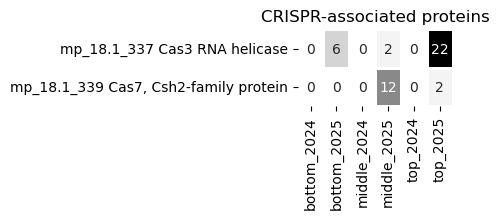

In [ ]:
# mp_18.1_337
# mp_18.1_339
cas_gene_ids = ['mp_18.1_331', 'mp_18.1_332', 'mp_18.1_333', 'mp_18.1_337','mp_18.1_338', 'mp_18.1_339', 'mp_18.1_340']
figure_df = metat_df[metat_df.gene_id.isin(['mp_18.1_337', 'mp_18.1_339'])].copy()
figure_df['annotation'] = figure_df.gene_id.map({'mp_18.1_337':'Cas3 RNA helicase', 'mp_18.1_339':'Cas7, Csh2-family protein'})
plot_read_counts(figure_df, title='CRISPR-associated proteins', figsize=(2, 1))

In [ ]:
diff_dfs = dict()
diff_dfs['top'] = metat_get_diff(metat_df, location='top', genome_id='mp_18', normalization='alr', threshold=10, ref_gene_ids= mcr_ref_gene_ids)
diff_dfs['middle'] = metat_get_diff(metat_df, location='middle', genome_id='mp_18', normalization='alr', threshold=10, ref_gene_ids= mcr_ref_gene_ids)
diff_dfs['bottom'] = metat_get_diff(metat_df, location='bottom', genome_id='mp_18', normalization='alr', threshold=10, ref_gene_ids= mcr_ref_gene_ids)

NameError: name 'mcr_ref_gene_ids' is not defined

In [ ]:
# # How many genes are common in both samples?
# locations = ['top', 'middle', 'bottom']
# thresholds = {'top':-0, 'middle':-0, 'bottom':-1}

# fig, ax = plt.subplots(figsize=(3, 3))
# figure_df = pd.DataFrame(index=locations, columns=locations)
# for location_x, location_y in itertools.product(locations, locations):
#     location_x_gene_ids = diff_dfs[location_x][diff_dfs[location_x]['diff'] > thresholds[location_x]].gene_id.unique()
#     location_y_gene_ids = diff_dfs[location_y][diff_dfs[location_y]['diff'] > thresholds[location_y]].gene_id.unique()
#     figure_df.loc[location_x, location_y] = len(np.intersect1d(location_x_gene_ids, location_y_gene_ids))

# sns.heatmap(figure_df.astype(int), cmap='Grays', annot=figure_df, cbar=False, lw=3)
# ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), rotation=0)
# plt.show()

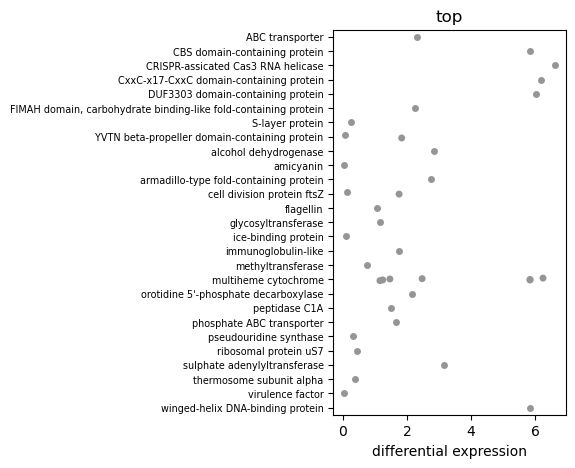

In [ ]:
def plot_differential_expression(drop_unannotated:bool=True, title:str='', thresholds = {'top':-0, 'middle':-0, 'bottom':-1}, locations=None, legend:bool=True, annotations=annotations):
    fig, ax = plt.subplots(figsize=(3, 5))
    
    annotations = {gene_id:description for annotations_ in annotations.values() for gene_id, description in annotations_.items()}

    figure_df = pd.concat([diff_dfs[location][diff_dfs[location]['diff'] > thresholds[location]] for location in locations])
    figure_df['annotation'] = figure_df.gene_id.map(annotations)
    figure_df['annotation'] = figure_df.annotation.fillna('none')
    figure_df = figure_df.sort_values(['annotation', 'diff'])
    if drop_unannotated:
        figure_df = figure_df[figure_df.annotation != 'none'].copy()

    figure_df = figure_df[~figure_df.gene_id.isin(rnap_ref_gene_ids + mcr_ref_gene_ids)].copy()

    # sns.stripplot(figure_df, x='diff', y='gene_id', hue='location', palette='Grays')
    sns.stripplot(figure_df, x='diff', y='annotation', hue='location', palette='Grays', legend=legend)
    ax.set_ylabel('')
    ax.set_xlabel('differential expression')
    y_tick_labels = [annotations.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()]
    ax.set_yticks(ax.get_yticks(), y_tick_labels, fontsize='x-small')
    if legend:
        ax.get_legend().set_title('')
    ax.set_title(title)
    plt.show()

plot_differential_expression(locations=['top'], title='top', thresholds={'top':0}, legend=False)


In [ ]:
# interproscan_df[interproscan_df.signature_description.str.contains('nitrate|nitrite', case=False) & (interproscan_df.genome_id == 'mp_2')].sort_values('gene_id')
# interproscan_df[interproscan_df.signature_description.str.contains('iron', case=False) & (interproscan_df.genome_id == 'mp_1')].sort_values('gene_id')

# # These three proteins seem to exist in an operon. 
# # DMSO/Nitrate reductase chaperone (PF02613)
# # Nitrate reductase beta subunit (PTHR43518)
# # MopB Nitrate-R-NarG-like domain-containing protein (cd02750)

# # mp_5 14_65 14_66 14_63
# # mp_1 24_19 24_21 24_22
# # mp_4 74_3 74_4
# # mp_2 none
# # mp_3 231_6

# # https://pmc.ncbi.nlm.nih.gov/articles/PMC9295563/

In [ ]:
# fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
# genome_id = 'mp_18'
# figure_df = metat_df[(metat_df.genome_id == genome_id) & (metat_df.reactor == 'n')].copy()
# # figure_df = figure_df[figure_df.read_count > 0].copy() # Consider only nonzero genes. 
# # sns.kdeplot(figure_df, x='read_count', hue='sample_id', common_norm=False, palette='Grays')
# x_mins = {'top':0.5, 'middle':0.7, 'bottom':0.85}
# for ax, (location, df) in zip(axes, figure_df.groupby('location')):
#     sns.ecdfplot(df, x='read_count', hue='year', palette='Grays', ax=ax)
#     ax.set_xlim(xmin=0, xmax=40)
#     ax.set_ylim(ymin=x_mins[location], ymax=1)
#     ax.get_legend().set_title('')
#     ax.set_ylabel('proportion')
#     ax.set_xlabel('read count')
#     ax.set_title(location)
#     sns.move_legend(ax, loc='lower right')

#     palette = {2:'lightblue', 5:'lightgray', 10:'steelblue'}
#     for threshold, color in palette.items():
#         ax.axvline(threshold, ls='--', color=color, lw=2)
#         print(f'Num. 2024 genes in {location} with counts > {threshold}:', ((df.year == '2024') & (df.read_count >= threshold)).sum())
#         print(f'Num. 2025 genes in {location} with counts > {threshold}:', ((df.year == '2025') & (df.read_count >= threshold)).sum())

# fig.tight_layout()
# plt.show()


In [ ]:
# def get_gene_set(metat_df:pd.DataFrame, accessions:dict, interproscan_df:pd.DataFrame=interproscan_df, single_copy:bool=True):
#     interproscan_df = interproscan_df[interproscan_df.interpro_accession.isin(accessions.keys())].copy()
#     interproscan_df = interproscan_df[['interpro_accession', 'gene_id', 'e_value']].copy()
#     metat_df = metat_df.merge(interproscan_df, on='gene_id', how='inner')
#     metat_df = metat_df.sort_values('e_value') # If dropping duplicates, keep the hit with the highest E-value.
#     metat_df['annotation'] = metat_df.interpro_accession.map(accessions)
#     if single_copy: # Make sure there is at most one of each annotation per genome. 
#         metat_df = metat_df.drop_duplicates(['genome_id', 'annotation', 'sample_id'], keep='first')
#     metat_df = metat_df.drop_duplicates(['gene_id', 'sample_id'])
#     return metat_df 

# rnap_metat_df = get_gene_set(metat_df[is_mp(metat_df)].copy(), rnap_accessions)
# mcr_metat_df = get_gene_set(metat_df[is_mp(metat_df)].copy(), mcr_accessions, single_copy=True)

In [ ]:
# Reference set requirements (per organism):
# (1) At least one detected in each sample. 
# (2) Housekeeping genes. 

# genome_id = 'mp_15'
# metat_df_ = metat_df[metat_df.genome_id == genome_id].copy()
# metat_df_ = metat_df_[metat_df_.read_count > 0].copy()

# ref_genes_df = pd.DataFrame(metat_df_.groupby('gene_id').sample_id.nunique()).rename(columns={'sample_id':'n_samples'})
# ref_genes_df = ref_genes_df.sort_values('n_samples')
# ref_genes_df = ref_genes_df.reset_index()

# mask = (interproscan_df.interpro_accession != '-') & (~interproscan_df.duplicated(['gene_id', 'interpro_accession'], keep='first'))
# ref_genes_df = ref_genes_df.merge(interproscan_df[mask][['interpro_accession', 'interpro_description', 'gene_id']], on='gene_id', how='left')

# for gene_id, df in ref_genes_df[ref_genes_df.n_samples > 3].sort_values('n_samples').groupby('gene_id'):
#     for row in df.itertuples():
#         print(f'{genome_id},{row.gene_id},{row.n_samples},{row.interpro_accession},{row.interpro_description}')
#     print()

In [ ]:
# Want to normalize based on some set of housekeeping genes, possibly the ribosomal proteins. 

# pattern = r'[a-z]*((L\d+)|(S\d+)|(P\d+))'
# get_ribosomal_protein = lambda description : re.search(pattern, description).group(0) if (re.search(pattern, description)) else None

# with warnings.catch_warnings():
#     warnings.filterwarnings('ignore')
#     mask = interproscan_df.signature_description.str.contains('ribosomal', case=False) 
#     # mask = mask & (interproscan_df.signature_accession != '-')
#     mask = mask & (interproscan_df.interpro_accession != '-')
#     mask = mask & (interproscan_df.gene_id.str.contains('mp_'))
#     mask = mask & ~interproscan_df.interpro_accession.duplicated(keep='first')
#     mask = mask & interproscan_df.signature_description.str.contains(pattern, regex=True)

# ref_protein_accessions = interproscan_df[mask].interpro_accession.unique()

In [ ]:
# ref_metat_df = metat_df[is_mp(metat_df) & (metat_df.interpro_accession.isin(ref_protein_accessions))].copy()
# ref_metat_df = ref_metat_df.sort_values('e_value').drop_duplicates('gene_id')

# ref_gene_ids = list()
# for genome_id, df in ref_metat_df.groupby('genome_id'):
#     print(f'Num. ribosomal protein hits in {genome_id}:', len(df))
#     ref_gene_ids += df.gene_id.unique().tolist()
# ref_gene_ids = {genome_id:df.gene_id.unique() for genome_id, df in ref_metat_df[ref_metat_df.gene_id.isin(ref_gene_ids)].groupby('genome_id')}

# # The whole point of using ALR is to allow comparison across samples without relying on the assumption that the baseline level of 
# # expression is the same. I think the peaks of the diff_df values should line up at zero, so something is going on. Maybe need to do 
# # a better job of picking individual reference sets for each organism. 

In [ ]:
# def plot_detected_genes(metat_df, genome_id:str='mp_18', log10_scale:bool=False):

#     fig, ax = plt.subplots(figsize=(3, 2)) 

#     get_n_shared_genes = lambda df : len(np.intersect1d(df[(df.year == '2024') & (df.read_count > 0)].gene_id.unique(), df[(df.year == '2025') & (df.read_count > 0)].gene_id.unique()))

#     metat_df = metat_df[(metat_df.reactor == 'n') & (metat_df.genome_id == genome_id)].copy()

#     figure_df = list()
#     for location, df in metat_df.groupby('location'):
#         figure_df.append({'category':'shared', 'n':get_n_shared_genes(df), 'location':location})
#         figure_df.append({'category':'2024', 'n':((df.year == '2024') & (df.read_count > 0)).sum(), 'location':location})
#         figure_df.append({'category':'2025', 'n':((df.year == '2025') & (df.read_count > 0)).sum(), 'location':location})
#     figure_df = pd.DataFrame(figure_df)
#     if log10_scale:
#         figure_df['n'] = np.log10(figure_df['n'])
#     n_total = metat_df.gene_id.nunique()

#     sns.barplot(figure_df, y='n', x='location', hue='category', palette='Grays', ax=ax, edgecolor='black')
#     ax.set_xlabel('')
#     ax.set_ylabel('count')
#     ax.get_legend().set_title('')
#     ax.set_title(f'$n={n_total}$')

#     if log10_scale:
#         ax.set_ylabel('$log_{10}(count)$')
#     plt.show()

# plot_detected_genes(metat_df, log10_scale=False, genome_id='mp_18')

In [ ]:
# def plot_genome_read_counts(metat_df:pd.DataFrame, title='', figsize=(3, 5), reactor:str='n'):

#     fig, ax = plt.subplots(figsize=figsize)
#     cmap = ListedColormap(["white", "steelblue"])
    
#     figure_df = metat_df[metat_df.reactor == reactor].copy()
#     figure_df = figure_df.groupby(['genome_id', 'sample_id']).read_count.sum()
#     figure_df = figure_df.reset_index()
#     figure_df = figure_df.pivot(columns='sample_id', values='read_count', index='genome_id')
#     figure_df.columns = figure_df.columns.str.replace('_metat', '')
#     figure_df = figure_df.fillna(0).astype(int)

#     sns.heatmap(pd.DataFrame(np.where(figure_df > 0, True, False), index=figure_df.index, columns=figure_df.columns), annot=figure_df, fmt='d', cmap=cmap, lw=1, cbar=False)
#     ax.set_ylabel('')
#     ax.set_xlabel('')
#     ax.set_title(title)
#     ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), rotation=0)
#     plt.show() 

# # plot_genome_read_counts(pd.concat([rnap_metat_df, mcr_metat_df]), figsize=(4, 6))
# plot_genome_read_counts(mcr_metat_df[mcr_metat_df.genome_id.isin(mp_genome_ids)].copy(), figsize=(4, 6), title='mcrAB reference counts')
# plot_genome_read_counts(rnap_metat_df[rnap_metat_df.genome_id.isin(mp_genome_ids)].copy(), figsize=(4, 6), title='RNA polymerase reference counts')